## `Loan Default Prediction` using ML Algorithms

### Problem Statement
The problem is to predict the probability of a `loan default`. The dataset contains information about the loan and the borrower. The dataset is highly `imbalanced` with the majority of the loans being `non-default`. The goal is to predict the probability of a loan default.

In [117]:
# necessary imports
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb

import git 

import warnings
warnings.filterwarnings('ignore')

In [82]:
plt.rcParams['figure.figsize'] = (13,8)
%config InlineBackend.figure_format = 'retina'

sns.set_style("darkgrid")
color_palette = sns.color_palette("colorblind")

### 1. Load the data and EDA

In [83]:
repoPath = git.Repo('.', search_parent_directories=True)

dataPath = f"{repoPath.working_tree_dir}/data/loan_default/Loan_default.csv"

In [84]:
# load the data
df = pd.read_csv(dataPath)
print("Shape of the data: ", df.shape)
df.head()

Shape of the data:  (255347, 18)


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [85]:
# check if there are any null values
#print(df.isnull().sum())
# check if there are any missing values
#print(df.isna().sum())

There is no missing or null values in the dataset. So, we don't need to do any data cleaning. However, we can just drop "LoandID" column as it doesn't contribute to the prediction. Furthermore, we need to convert categorical columns to numerical columns.

#### 1.1 Default likelihood by education level

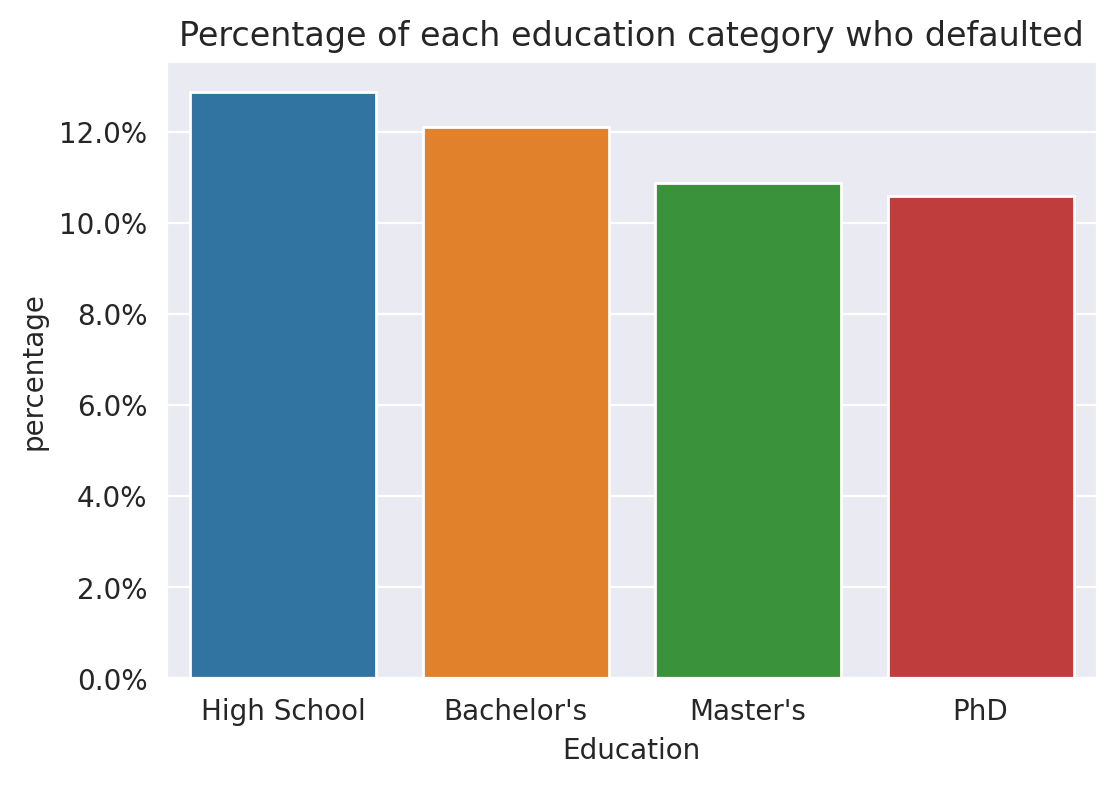

In [86]:
# find percentage of each education category who defaulted
df_education = df.groupby(['Education', 'Default'])['Default'].count().reset_index(name='count').sort_values(['Education', 'Default'], ascending=False)
df_education['percentage'] = df_education['count'].div(df_education.groupby('Education')['count'].transform('sum')).mul(100)
df_education_default = df_education[df_education['Default'] == 1]
df_education_default = df_education_default.sort_values(['percentage'], ascending=False)

# plot the percentage of each education category who defaulted
plt.figure(figsize=(6,4))
sns.barplot(x='Education', y='percentage', data=df_education_default, hue='Education')
# show percentage on y-axis
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('Percentage of each education category who defaulted')
plt.show()

#### 1.2 Default likelihood by EmploymentType

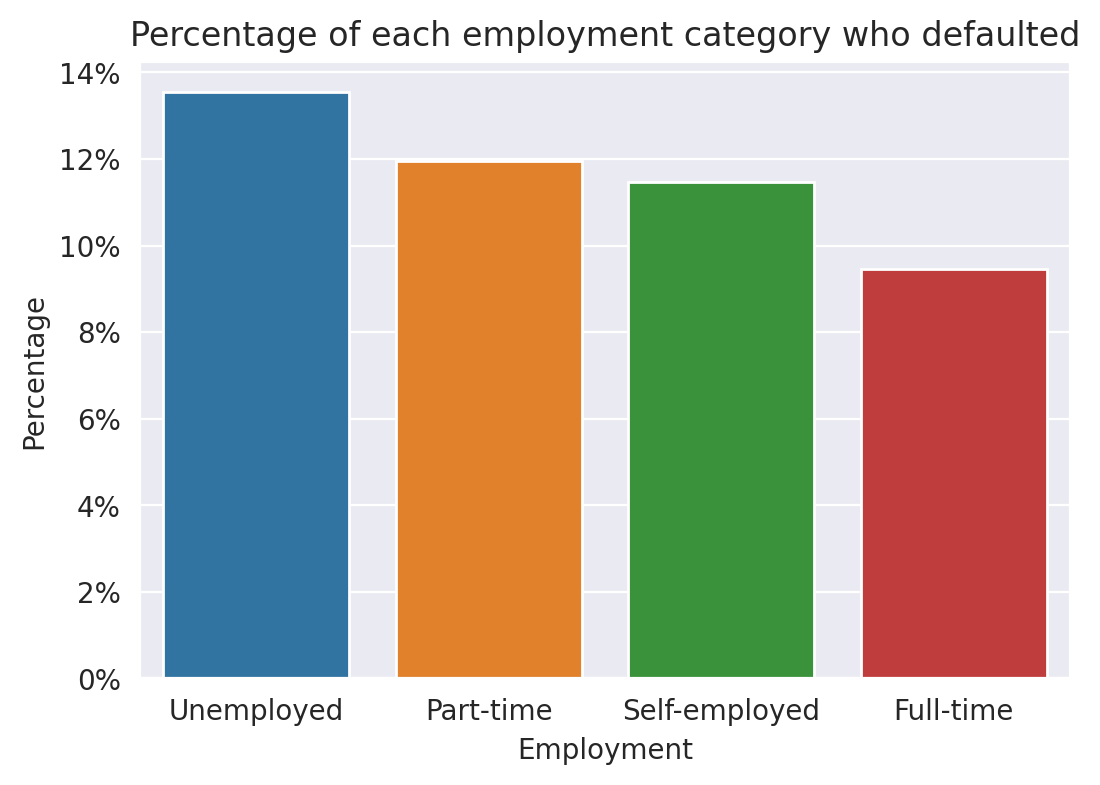

In [87]:
df_emp = df.groupby(['EmploymentType', 'Default'])['Default'].count().reset_index(name='count').sort_values(['EmploymentType', 'Default'], ascending=False)
df_emp['percentage'] = df_emp['count'].div(df_emp.groupby('EmploymentType')['count'].transform('sum')).mul(100)
df_emp_default = df_emp[df_emp['Default'] == 1]
df_emp_default = df_emp_default.sort_values(['percentage'], ascending=False)

# plot the percentage of each employment category who defaulted
plt.figure(figsize=(6,4))
sns.barplot(x='EmploymentType', y='percentage', data=df_emp_default, hue='EmploymentType')
plt.title('Percentage of each employment category who defaulted')
plt.xlabel('Employment')
plt.ylabel('Percentage')

# format y-axis as percentage
fmt = '%.0f%%' # specify the format as percentage with 0 decimal places
yticks = mtick.FormatStrFormatter(fmt)
plt.gca().yaxis.set_major_formatter(yticks)

plt.show()

### 2. Encoding categorical columns and Coorelation

In [88]:
# drop LoanID
df.drop(['LoanID'], axis=1, inplace=True)

In [89]:
# encode the categorical variables
def encode_categorical(df:pd.DataFrame)->pd.DataFrame:
    """
    This function encodes the categorical variables in the dataframe
    """
    le = LabelEncoder()
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = le.fit_transform(df[col])
    return df

In [90]:
df = encode_categorical(df)
df.head()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,56,85994,50587,520,80,4,15.23,36,0.44,0,0,0,1,1,4,1,0
1,69,50432,124440,458,15,1,4.81,60,0.68,2,0,1,0,0,4,1,0
2,46,84208,129188,451,26,3,21.17,24,0.31,2,3,0,1,1,0,0,1
3,32,31713,44799,743,0,3,7.07,24,0.23,1,0,1,0,0,1,0,0
4,60,20437,9139,633,8,4,6.51,48,0.73,0,3,0,0,1,0,0,0


In [91]:
# check the correlation between the target variable and other variables
corr = df.corr()['Default'].sort_values()

In [92]:
corr

Age              -0.167783
Income           -0.099119
MonthsEmployed   -0.097374
HasCoSigner      -0.039109
HasDependents    -0.034678
CreditScore      -0.034166
HasMortgage      -0.022856
Education        -0.022835
LoanPurpose      -0.010096
MaritalStatus    -0.007902
LoanTerm          0.000545
DTIRatio          0.019236
NumCreditLines    0.028330
EmploymentType    0.041010
LoanAmount        0.086659
InterestRate      0.131273
Default           1.000000
Name: Default, dtype: float64

Not all features are `strongly` correlated to the target column. This means that not every piece of information we have about a loan applicant will directly influence whether they will default on their loan or not. It's important to identify and focus on the features that have the strongest correlation with the target column for the predictive model to be effective.
Let's choose the features that have a `correlation of more than 0.05 or less than -0.05 with the target column`.

In [93]:
# choose the features with correlation greater than 0.05
features = corr[abs(corr) > 0.05]
df_new = df[features.index]

In [94]:
df_new.corr()['Default'].sort_values()

Age              -0.167783
Income           -0.099119
MonthsEmployed   -0.097374
LoanAmount        0.086659
InterestRate      0.131273
Default           1.000000
Name: Default, dtype: float64

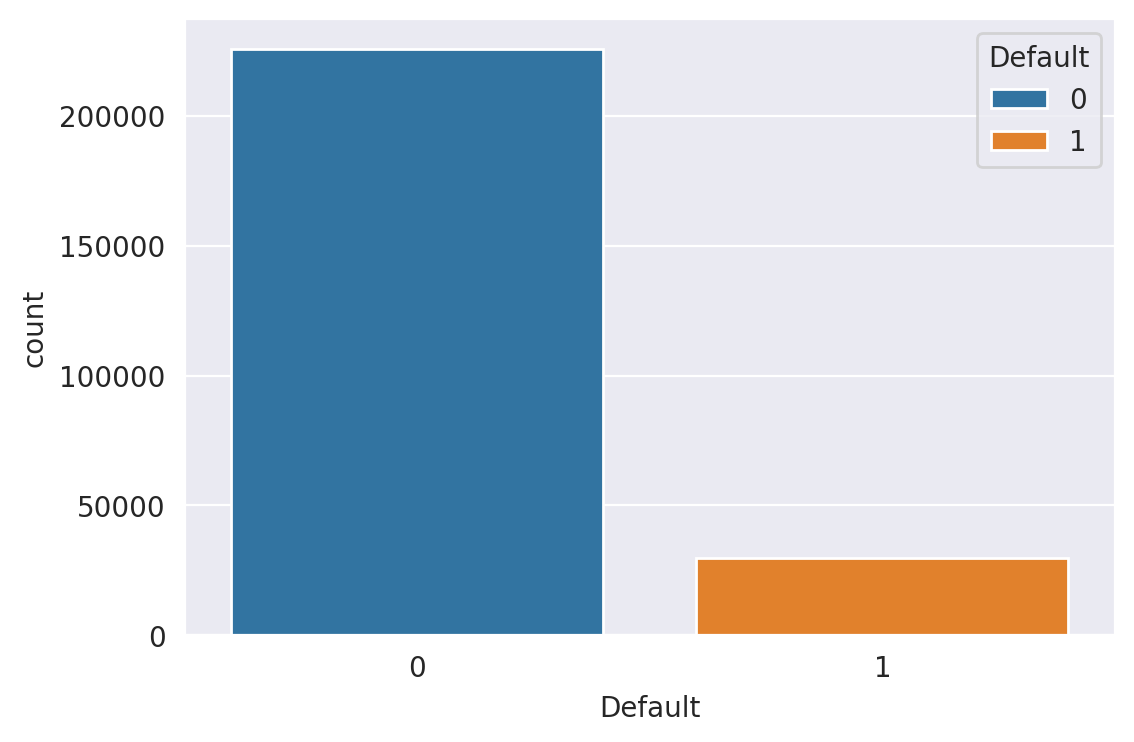

In [95]:
# count plot for the target variable
plt.figure(figsize=(6,4))
sns.countplot(x = 'Default', data=df_new, hue='Default')
plt.show()

The dataset is highly `imbalanced` with the majority of the loans being non-default. This is exactly what makes this problem a bit challenging and interesting. We need to handle this imbalance in the dataset.

Let's first train a model without handling the imbalance and see how it performs.

### 3. Train and Test Split 

In [96]:
# split the data into train and test
# randomly choose 70% of the data for training and 30% for testing
X = df_new.drop(['Default'], axis=1).values
y = df_new['Default'].values
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3, random_state=42)

In [97]:
np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

((array([0, 1]), array([158013,  20729])),
 (array([0, 1]), array([67681,  8924])))

### 4. Classification Models

We will use `XGBoost` classifier for this problem. However, we can also use other classifiers like `Random Forest`, `Logistic Regression`, etc.

In [109]:
# make a classifier function to train and test the model
def xgb_classifier(X_train, X_test, y_train, y_test, print_results=True, params:dict={}):
    """
    This function trains and tests the XGBoost classifier
    """
    # create the classifier
    clf = xgb.XGBClassifier(**params)

    # train the classifier
    clf.fit(X_train, y_train)

    # predict the values
    y_pred = clf.predict(X_test)

    accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
    classification_report = sklearn.metrics.classification_report(y_test, y_pred)

    print("====================================================================")
    print("Accuracy: ", accuracy)
    print("====================================================================")
    print("Classification report: \n", classification_report)
    print("====================================================================")

    return accuracy, classification_report


In [110]:
# train and test the model
_, _ = xgb_classifier(X_train, X_test, y_train, y_test)

Accuracy:  0.8841720514326741
Classification report: 
               precision    recall  f1-score   support

           0       0.89      0.99      0.94     67681
           1       0.52      0.06      0.11      8924

    accuracy                           0.88     76605
   macro avg       0.71      0.53      0.52     76605
weighted avg       0.85      0.88      0.84     76605



We got the classification accuracy! Great! But, what does this number really tell us? Let's look at the classification report to see the precision and recall values for each class.

Not very good! We can see that the model is really bad at predicting the minority class. It has a very low precision and recall for the minority class. We need to find a way to improve the model's ability to predict the minority class!

### 5. Dealing with imbalanced classes

In [101]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

#### 5.1 Undersampling
The simplest way to deal with imbalanced classes is to `undersample` the majority class. We can do this by randomly selecting same number of samples from the majority class as there are in the minority class.

In [103]:
# train test split 
rus = RandomUnderSampler(random_state=42)
X_train_us, y_train_us = rus.fit_resample(X_train, y_train)

# train and test the model
_, _ = xgb_classifier(X_train_us, X_test, y_train_us, y_test)

Accuracy:  0.6646694080020886
Classification report: 
               precision    recall  f1-score   support

           0       0.94      0.66      0.78     67681
           1       0.21      0.67      0.32      8924

    accuracy                           0.66     76605
   macro avg       0.57      0.66      0.55     76605
weighted avg       0.85      0.66      0.72     76605



The model is now able to predict the minority class better. However, this is still much worse than what we would expect from a good model. We need to find a better way to handle the imbalance in the dataset.

#### 5.2 Oversampling

Another way to deal with imbalanced classes is to `oversample` the minority class. We can do this by randomly selecting same number of samples from the minority class as there are in the majority class.

In [104]:
ros = RandomOverSampler(random_state=42)
X_train_os, y_train_os = ros.fit_resample(X_train, y_train)

# train and test the model
_, _ = xgb_classifier(X_train_os, X_test, y_train_os, y_test)

Accuracy:  0.703452777233862
Classification report: 
               precision    recall  f1-score   support

           0       0.93      0.71      0.81     67681
           1       0.22      0.62      0.33      8924

    accuracy                           0.70     76605
   macro avg       0.58      0.67      0.57     76605
weighted avg       0.85      0.70      0.75     76605



Like, before, we would like the model to predict the minority class better. However, this is still not good enough!

#### 5.3 SMOTE
`SMOTE` stands for `Synthetic Minority Oversampling Technique`. Unlike random oversampling, `SMOTE` does not create exact copies of observations from the minority class. Instead, `SMOTE` creates new, `synthetic`, samples that are quite similar to the existing observations in the minority class.

In [105]:
# SMOTE
smk = SMOTETomek(random_state=42)
X_smk, y_smk = smk.fit_resample(X, y)

# check the class distribution
np.unique(y_smk, return_counts=True)

(array([0, 1]), array([201433, 201433]))

It's a good balance now between both classes.

In [106]:
# train and test the model
X_train_smk, X_test_smk, y_train_smk, y_test_smk = train_test_split(X_smk, y_smk, test_size=0.3, random_state=42)

# train and test the model
_, _ = xgb_classifier(X_train_smk, X_test_smk, y_train_smk, y_test_smk)

Accuracy:  0.8636190633791163
Classification report: 
               precision    recall  f1-score   support

           0       0.82      0.94      0.87     60593
           1       0.93      0.79      0.85     60267

    accuracy                           0.86    120860
   macro avg       0.87      0.86      0.86    120860
weighted avg       0.87      0.86      0.86    120860



Boom! We have improved the model's ability to predict the minority class. The `precision` and `recall` values for the minority class have improved significantly. The model is now able to predict the minority class with a good `precision` and `recall`. The precision and recall values for the majority class have also improved!

#### 5.4 Balanced Bagging Classifier

`BalancedBaggingClassifier` is a type of ensemble learning technique. It is an `ensemble learning` technique that combines the predictions from multiple machine learning algorithms together to make more accurate predictions than any individual model.

In [74]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [75]:
# Balanced Bagging Classifier
clf = BalancedBaggingClassifier(base_estimator=XGBClassifier(), sampling_strategy='auto', replacement=False, random_state=42)

# fit the classifier
clf.fit(X_train, y_train)

# predict the values
y_pred = clf.predict(X_test)

accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
classification_report = sklearn.metrics.classification_report(y_test, y_pred)

In [76]:
print("====================================================================")
print("Accuracy: ", accuracy)
print("====================================================================")
print("Classification report: \n", classification_report)
print("====================================================================")

Accuracy:  0.7017688140460805
Classification report: 
               precision    recall  f1-score   support

           0       0.94      0.71      0.81     67681
           1       0.23      0.65      0.34      8924

    accuracy                           0.70     76605
   macro avg       0.58      0.68      0.57     76605
weighted avg       0.86      0.70      0.75     76605



### 6. Hyperparameter Tuning

- We will use Optuna to tune the hyperparameters of the `XGBoost` classifier.
- We will use SMOTE to handle the imbalance in the dataset.

In [108]:
import optuna

In [118]:
# define the objective function
def objective(trial):

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # define the parameters
    param = {
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 300, 400, 500]),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),

        'objective': 'binary:logistic',
        'n_jobs': -1,
        'tree_method': 'gpu_hist' if device == 'cuda' else 'auto',
        'random_state': 42
    }
    

    # create the classifier
    clf = xgb.XGBClassifier(**param)
    
    # train the classifier
    clf.fit(X_train_smk, y_train_smk)

    # predict the values
    y_pred = clf.predict(X_test_smk)

    accuracy = sklearn.metrics.accuracy_score(y_test_smk, y_pred)

    return accuracy

In [120]:
# create the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=2)

[I 2024-04-01 12:28:10,816] A new study created in memory with name: no-name-70e4cad5-7c41-46be-99a5-c92e51c6b2f2
[I 2024-04-01 12:28:12,974] Trial 0 finished with value: 0.7400049644216449 and parameters: {'max_depth': 8, 'n_estimators': 100, 'learning_rate': 0.01224343016084542, 'subsample': 0.1568916813917715, 'min_child_weight': 9}. Best is trial 0 with value: 0.7400049644216449.
[I 2024-04-01 12:28:16,022] Trial 1 finished with value: 0.8670941585305312 and parameters: {'max_depth': 6, 'n_estimators': 400, 'learning_rate': 0.13420701739003343, 'subsample': 0.3456334465817017, 'min_child_weight': 9}. Best is trial 1 with value: 0.8670941585305312.


In [121]:
# get the best parameters
best_params = study.best_params
best_params


{'max_depth': 6,
 'n_estimators': 400,
 'learning_rate': 0.13420701739003343,
 'subsample': 0.3456334465817017,
 'min_child_weight': 9}

In [122]:
# train and test the model
_, _ = xgb_classifier(X_train_smk, X_test_smk, y_train_smk, y_test_smk, params=best_params)

Accuracy:  0.8685338408075459
Classification report: 
               precision    recall  f1-score   support

           0       0.82      0.94      0.88     60593
           1       0.93      0.79      0.86     60267

    accuracy                           0.87    120860
   macro avg       0.88      0.87      0.87    120860
weighted avg       0.88      0.87      0.87    120860



### 7. Conclusion

We have successfully predicted the probability of a loan default using `XGBoost` classifier. We have also handled the imbalance in the dataset using methods like `Undersampling`, `Oversampling`, `SMOTE`, and `BalancedBaggingClassifier`. Out of all these methods, `SMOTE` gave the best results. Finally, we have tuned the hyperparameters of the `XGBoost` classifier using `Optuna` and got the best parameters that gave the best results.